In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [10]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255
#x_train, x_test = x_train / 255.0, x_test / 255.0

In [11]:
y_train = y_train.reshape(60000,1)
y_test = y_test.reshape(10000,1)

In [108]:
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.shuffle(buffer_size=1024).batch(64)


y_train = tf.data.Dataset.from_tensor_slices(y_train)
y_train = y_train.shuffle(buffer_size=1024).batch(64)

In [95]:
class MLP(Model):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, outputs):
        super(MLP, self).__init__()

        self.hidden1 = layers.Dense(hidden1, activation='relu', name='hidden1') # 500
        self.hidden2 = layers.Dense(hidden2, activation='relu', name='hidden2') # 300
        self.hidden3 = layers.Dense(hidden3, activation='relu', name='hidden3') # 100
        self.hidden4 = layers.Dense(10, name='hidden4')
        self.outputs = layers.Softmax(name = 'output') # 10
        
        #self.droupout = Droupout(0.2)
        self.input_dim = input_dim
    
    def build_graph(self):
        inputs_ = layers.Input(shape=self.input_dim, name = 'inputs')
        return Model(inputs=inputs_, outputs=self.call(inputs_))
        #self._init_graph_network(inputs=self.input_layer,outputs=self.out)
        
#     def model(self):
#         x = layers.Input(shape=self.input_dim)
#         return Model(inputs=x, outputs=self.call(x))

    def call(self, input_data, training=False):
        x = self.hidden1(input_data)
        #if training == True:
            #x = self.droupout(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.outputs(x)
        return x

In [83]:
mlp = MLP(784, 500, 300, 100, 10)

In [85]:
mlp.build((None, 784))

In [86]:
mlp.summary()

Model: "mlp_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              multiple                  392500    
_________________________________________________________________
hidden2 (Dense)              multiple                  150300    
_________________________________________________________________
hidden3 (Dense)              multiple                  30100     
_________________________________________________________________
hidden4 (Dense)              multiple                  1010      
_________________________________________________________________
output (Softmax)             multiple                  0         
Total params: 573,910
Trainable params: 573,910
Non-trainable params: 0
_________________________________________________________________


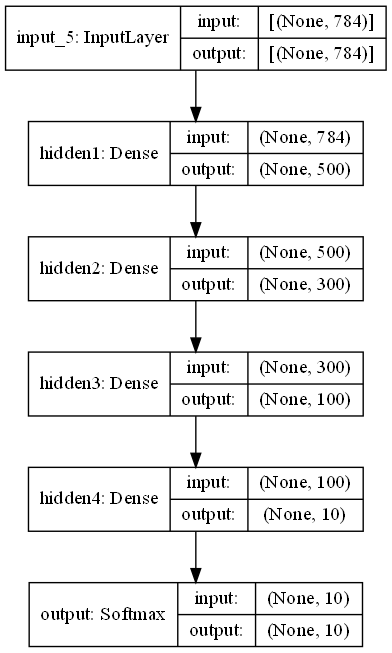

In [87]:
tf.keras.utils.plot_model(mlp.build_graph(), show_shapes=True, show_layer_names=True, rankdir='TB', dpi=100, expand_nested=True)

In [112]:
class Trainer:
    def __init__(self,args, train, test):
        self.args = args
        self.x_train = train[0]
        self.y_train = train[1]
        
        self.x_test = test[0]
        self.y_test = test[1]
    
    def train_mlp1(self):
        mlp = MLP(784, 500, 300, 100, 10).build_graph()
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
        optimizer = tf.keras.optimizers.Adam()

        mlp.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])
        hist = mlp.fit(x=self.x_train, y=self.y_train, batch_size = 64, epochs=self.args['epochs'], )
        
        return mlp
    
    def train_mlp(self):
        
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
        optimizer = tf.keras.optimizers.Adam()
        
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
        
        mlp = MLP(784, 500, 300, 100, 10)
        
        for epoch in range(self.args['epochs']):
            print("Start of epoch %d" % (epoch,))

            # Iterate over the batches of the dataset.
            loss_tracker = 0
            for step, (x_batch_train, y_batch_train) in enumerate(zip(self.x_train, self.y_train)):
                with tf.GradientTape() as tape:
                    output = mlp(x_batch_train)
                    loss = loss_object(y_batch_train, output)
                    #loss += sum(mlp.losses) 

                grads = tape.gradient(loss, mlp.trainable_weights)
                optimizer.apply_gradients(zip(grads, mlp.trainable_weights))

                train_loss(loss)
                train_accuracy(y_batch_train, output)
                
                if step % 100 == 0:
                    
                    template = 'Step: {}, 손실: {:.3f}, 정확도: {:.3f}'
                    print(template.format(step,
                                          train_loss.result(),
                                          train_accuracy.result()*100))
                    
                    #print(f"Step: {step}, loss: {train_loss.result()}")
                    #print("step %d: mean loss = %.4f" % (step, train_loss.result()))
            print(f"epoch: {epoch+1}, Loss: {loss_tracker}")
        
                    
    def eval_step(self):
        pass
        #prediction = 

In [113]:
args = {'epochs': 2}

simple_mlp = Trainer(args, train=[x_train, y_train], test=[x_test, y_test])

In [114]:
#model = simple_mlp.train_mlp1()
simple_mlp.train_mlp()

Start of epoch 0
Step: 0, 손실: 2.338, 정확도: 10.938
Step: 100, 손실: 2.312, 정확도: 10.489
Step: 200, 손실: 2.308, 정확도: 10.401
Step: 300, 손실: 2.306, 정확도: 10.444
Step: 400, 손실: 2.305, 정확도: 10.665
Step: 500, 손실: 2.305, 정확도: 10.685
Step: 600, 손실: 2.305, 정확도: 10.766
Step: 700, 손실: 2.304, 정확도: 10.835
Step: 800, 손실: 2.304, 정확도: 10.842
Step: 900, 손실: 2.304, 정확도: 10.816
epoch: 1, Loss: 33.84674072265625
Start of epoch 1
Step: 0, 손실: 2.304, 정확도: 10.792
Step: 100, 손실: 2.303, 정확도: 10.827
Step: 200, 손실: 2.303, 정확도: 10.868
Step: 300, 손실: 2.303, 정확도: 10.917
Step: 400, 손실: 2.303, 정확도: 10.954
Step: 500, 손실: 2.303, 정확도: 10.998
Step: 600, 손실: 2.303, 정확도: 11.010
Step: 700, 손실: 2.303, 정확도: 11.036
Step: 800, 손실: 2.303, 정확도: 11.023
Step: 900, 손실: 2.303, 정확도: 10.995
epoch: 2, Loss: 33.78902816772461


In [99]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
hidden1 (Dense)              (None, 500)               392500    
_________________________________________________________________
hidden2 (Dense)              (None, 300)               150300    
_________________________________________________________________
hidden3 (Dense)              (None, 100)               30100     
_________________________________________________________________
hidden4 (Dense)              (None, 10)                1010      
_________________________________________________________________
output (Softmax)             (None, 10)                0         
Total params: 573,910
Trainable params: 573,910
Non-trainable params: 0
_____________________________________________________

In [103]:
part = Model(model.get_layer('inputs').input, model.get_layer('hidden2').output)
#stat_AE = Model(combination.get_layer('stat_inputs').input, combination.get_layer('STAT_AE').output)
#model.get_layer('hidden1')

In [104]:
part.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
hidden1 (Dense)              (None, 500)               392500    
_________________________________________________________________
hidden2 (Dense)              (None, 300)               150300    
Total params: 542,800
Trainable params: 542,800
Non-trainable params: 0
_________________________________________________________________


In [54]:
Model(layers.Input(768).Input, model.get_layer('hidden3').output)

AttributeError: 'KerasTensor' object has no attribute 'Input'

In [151]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32") / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [41]:
for i in train_dataset:
    print(i)
    break

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 784), dtype=float32)


In [68]:
for key, values in enumerate(zip(y_train, y_test)):
    print(values[0])
    print(values[1])
    break

5
7
